Regression
 - Use when you want to predict target scalar values based on scalar value inputs; as opposed to predicting the class that an object belongs to
 - Regression examples: predicting tomorrow's temperature, or price of a car
 - To implement in network, we will have to change our output layer and loss calculation (error calc)

Linear Activation:
- this will be used for the output layer
- it is just y = x, or outputs = inputs
- derivative wrt to input is 1, so just passing back gradients of loss layer
- this code really does nothing, we just do it for completeness and to have an ouput layer for better clarity in our code. It should add minimal amount to training time, if any.

In [ ]:
class Activation_Linear:
    # Forward pass
    def forward(self, inputs):
        # Just remember values
        self.inputs = inputs
        self.output = inputs
    # Backward pass
    def backward(self, dvalues):
        # derivative is 1, 1 * dvalues = dvalues - the chain rule
        self.dinputs = dvalues.copy()

Mean Squared Error Loss:
- the average of the squared difference between the outputs and their respective ground truth values for a particular sample
- Li = 1/J * sum((yij - y_hatij)^2); where Li = loss for sample i, J is the number of outputs, yij is ground truth, y_hatij is prediction
- the further we get from the ground truth, the more harshly the network is penalized because the loss grows quadratically
- Derivative (use chain rule): dLi/dy_hatij = d/dy_hatij ( 1/J * sum((yij - y_hatij)^2) ) = 1/J * d/dy_hatij sum((yij - y_hatij)^2) = 1/J * 2 (yij - y_hatij) * d/dy_hatij (yij - y_hatij) = 1/J * 2 (yij - y_hatij) * (0 - 1) = -2/J * (yij - y_hatij)

Mean Squared Error Loss code
- forward pass: remeber, axis = -1 takes average of row (aka outputs for a sample)
- backward pass: still doing gradient normalization via averaging

In [ ]:
# Mean Squared Error loss
class Loss_MeanSquaredError(Loss): # L2 loss
    # Forward pass
    def forward(self, y_pred, y_true):
        
        # Calculate loss
        sample_losses = np.mean((y_true - y_pred)**2, axis=-1)
        # Return losses
        return sample_losses
    
        # Backward pass
    def backward(self, dvalues, y_true):
        # Number of samples
        samples = len(dvalues)
        
        # Number of outputs in every sample
        # We'll use the first sample to count them
        outputs = len(dvalues[0])
        
        # Gradient on values
        self.dinputs = -2 * (y_true - dvalues) / outputs
        
        # Normalize gradient
        self.dinputs = self.dinputs / samples

Mean Absolute Error Loss
- average of the absolute value of the difference between ground truth and predicted values
- Li = 1/J * abs(yij - y_hatij); same definitions as above
- penalizes error linearly - error increases 1:1 the further you are from loss. Produces sparser results and is more robust to outliers. Sparsity means weights/biases that are 0, which can be beneficial for interpretability and feature selection, but can also make the model more unstable and passes up on incorporating that information. Can also be more computationally efficient and robust to outliers because of the 0s. Another general downside is that it is very sensitive to scaling of the training/testing data
- MAE (L1) used less frequently than MSE (L2)
- Derivative dLi/dy_hatij = d/dy_hatij ( 1/J * abs(yij - y_hatij) )=  1/J * d/dy_hatij * abs(yij - y_hatij); absolute value derivative 1 when term >= 0 or -1 when < 0; dLij = 1/J * {1; yij - y_hatij >= 0 or -1; yij - y_hatij < 0}; Remember that abs derivate is undefined at 0, but we just say it is 1 for ease

MAE Codes
- Forward Pass: same -1 axis concept in the forward pass mean
- Backward pass: use np.sign() to get the derivative of the abs

In [ ]:
# Mean Absolute Error loss
class Loss_MeanAbsoluteError(Loss): # L1 loss
    # Forward pass
    def forward(self, y_pred, y_true):
        # Calculate loss
        sample_losses = np.mean(np.abs(y_true - y_pred), axis=-1)
        # Return losses
        return sample_losses
    
    # Backward pass
    def backward(self, dvalues, y_true):
        # Number of samples
        samples = len(dvalues)
        # Number of outputs in every sample
        # We'll use the first sample to count them
        outputs = len(dvalues[0])
        # Calculate gradient
        self.dinputs = np.sign(y_true - dvalues) / outputs
        # Normalize gradient
        self.dinputs = self.dinputs / samples

Comparison between L1 (MAE) and L2 (MSE) (credit ChatGPT):
1. **Robustness to Outliers**:
   - L1 Loss: More robust to outliers because it doesn't square the errors. Outliers have a linear impact on the loss.
   - L2 Loss: Sensitive to outliers due to the squaring of errors. Outliers have a quadratic impact on the loss, making it less robust.

2. **Sparsity**:
   - L1 Loss: Encourages sparsity in the solution, meaning many coefficients can be exactly zero, effectively performing feature selection.
   - L2 Loss: Does not inherently encourage sparsity, leading to solutions where most coefficients are non-zero.

3. **Computational Efficiency**:
   - L1 Loss: Sparse solutions are computationally efficient because they involve fewer non-zero parameters.
   - L2 Loss: May involve more computational overhead due to non-sparsity.

4. **Solution Stability**:
   - L1 Loss: Can lead to less stable solutions, especially when features are highly correlated, as it may arbitrarily select one feature over another.
   - L2 Loss: Generally produces more stable solutions, particularly when features are correlated.

5. **Impact of Scaling**:
   - L1 Loss: Sensitive to feature scaling since it treats all errors equally regardless of their magnitude.
   - L2 Loss: Less sensitive to feature scaling due to the squaring of errors, but can still be affected by extreme feature values.

6. **Optimization Challenges**:
   - L1 Loss: Introduces non-differentiability at zero, which can make optimization challenging, especially in large-scale problems.
   - L2 Loss: Smooth and differentiable, making optimization relatively easier compared to L1 loss.

7. **Performance on Small Datasets**:
   - L1 Loss: May not perform well on small datasets where sparsity could be too aggressive, leading to underfitting.
   - L2 Loss: Generally performs well on small datasets, providing more stable estimates.

Accuracy Calculation:
- need a new way to calculate accuracy because cannot just check equivalence anymore. This will result in the model appearing to be very inaccurate, when in reality it is ok for something to just be close enough. Ex: ground truth = 100, predicted value = 99.999
- to do this, we need to calculate a cushion value, where we will consider something correct if it falls within the cushion. 
- one way: take the standard deviation of the ground truth values in the dataset, and divide by some scalar. The larger the scalar, the more strict/smaller our cushion is.
- then, variations from ground truth that are less than the cushion allowance are considered accurate/correct.
- Code example below: y=groud truth of data set; 250 is our scalar for the cushion size. Then we take the absolute value of the differnece between ground predicted values and ground truth and do a boolean check that it is within our cushion. If it is the value is 1, if not, it is 0. Then we average the 1s and 0s for our accuracy metric.

In [ ]:
accuracy_precision = np.std(y) / 250 #250 is the scalar

predictions = activation2.output #network outputs
accuracy = np.mean(np.absolute(predictions - y) < accuracy_precision)


Regression Code
- RUN THE LAST CELL IN WORKBOOK FOR THIS CODE TO WORK PROPERLY
- the version shown below is the best performing example from the book; however, earlier examples perform much worse. They are discussed below.
- Firstly, notice that for the accuracy precision cushion, we establish accuracy_precision variable at the end of all the initialization, then we calculate the accuracy during the loop
- Through the book we run the regression with 2 layers, then 3
- the first example in the book results: (2 layers, accuracy <1%)
- the final example - 3 layers with Optimizer_Adam(learning_rate=0.005, decay=1e-3); performs very well
- Note: experienced a lot of issues transcribing this code, so it is from the github and may not 100% match book if there were any changes from the book version to github version, but I couldn't find my error
- Also, discussed further below, but we changed the weight intialization draw from .01 * normal distribution to .1, for more accurate performance, but I found that I got much better performance with .01 and the default adam optimizer parameters. So not really sure what is going on there. I left it at .1 to stay consistent with book. I was able to replicate the results of the book at their settings.
- with book settings at a weight intialization scalar of .1, 3 layers with Optimizer_Adam(learning_rate=0.005, decay=1e-3), we get accuracy 87.7. It doesn't match performance of book - but I note that was able to get high 90s with scalar of .01 rather than .1
- Overall, there is a lot of jumping in the accuracy, which may show the the learning rate is too big

In [36]:
# Create dataset
X, y = sine_data()

# Create Dense layer with 1 input feature and 64 output values
dense1 = Layer_Dense(1, 64)

# Create ReLU activation (to be used with Dense layer):
activation1 = Activation_ReLU()

# Create second Dense layer with 64 input features (as we take output
# of previous layer here) and 64 output values
dense2 = Layer_Dense(64, 64)

# Create ReLU activation (to be used with Dense layer):
activation2 = Activation_ReLU()

# Create third Dense layer with 64 input features (as we take output
# of previous layer here) and 1 output value
dense3 = Layer_Dense(64, 1)

# Create Linear activation:
activation3 = Activation_Linear()

# Create loss function
loss_function = Loss_MeanSquaredError()

# Create optimizer
optimizer = Optimizer_Adam(learning_rate=0.005, decay=1e-3)


# Accuracy precision for accuracy calculation
# There are no really accuracy factor for regression problem,
# but we can simulate/approximate it. We'll calculate it by checking
# how many values have a difference to their ground truth equivalent
# less than given precision
# We'll calculate this precision as a fraction of standard deviation
# of all the ground truth values
accuracy_precision = np.std(y) / 250

# Train in loop
for epoch in range(10001):

    # Perform a forward pass of our training data through this layer
    dense1.forward(X)

    # Perform a forward pass through activation function
    # takes the output of first dense layer here
    activation1.forward(dense1.output)

    # Perform a forward pass through second Dense layer
    # takes outputs of activation function
    # of first layer as inputs
    dense2.forward(activation1.output)

    # Perform a forward pass through activation function
    # takes the output of second dense layer here
    activation2.forward(dense2.output)

    # Perform a forward pass through third Dense layer
    # takes outputs of activation function of second layer as inputs
    dense3.forward(activation2.output)

    # Perform a forward pass through activation function
    # takes the output of third dense layer here
    activation3.forward(dense3.output)

    # Calculate the data loss
    data_loss = loss_function.calculate(activation3.output, y)

    # Calculate regularization penalty
    regularization_loss = \
        loss_function.regularization_loss(dense1) + \
        loss_function.regularization_loss(dense2) + \
        loss_function.regularization_loss(dense3)

    # Calculate overall loss
    loss = data_loss + regularization_loss

    # Calculate accuracy from output of activation2 and targets
    # To calculate it we're taking absolute difference between
    # predictions and ground truth values and compare if differences
    # are lower than given precision value
    predictions = activation3.output
    accuracy = np.mean(np.absolute(predictions - y) <
                       accuracy_precision)

    if not epoch % 100:
        print(f'epoch: {epoch}, ' +
              f'acc: {accuracy:.3f}, ' +
              f'loss: {loss:.3f} (' +
              f'data_loss: {data_loss:.3f}, ' +
              f'reg_loss: {regularization_loss:.3f}), ' +
              f'lr: {optimizer.current_learning_rate}')

    # Backward pass
    loss_function.backward(activation3.output, y)
    activation3.backward(loss_function.dinputs)
    dense3.backward(activation3.dinputs)
    activation2.backward(dense3.dinputs)
    dense2.backward(activation2.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    # Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.update_params(dense3)
    optimizer.post_update_params()


epoch: 0, acc: 0.002, loss: 0.484 (data_loss: 0.484, reg_loss: 0.000), lr: 0.005
epoch: 100, acc: 0.007, loss: 0.061 (data_loss: 0.061, reg_loss: 0.000), lr: 0.004549590536851684
epoch: 200, acc: 0.231, loss: 0.001 (data_loss: 0.001, reg_loss: 0.000), lr: 0.004170141784820684
epoch: 300, acc: 0.018, loss: 0.001 (data_loss: 0.001, reg_loss: 0.000), lr: 0.003849114703618168
epoch: 400, acc: 0.485, loss: 0.000 (data_loss: 0.000, reg_loss: 0.000), lr: 0.0035739814152966403
epoch: 500, acc: 0.643, loss: 0.000 (data_loss: 0.000, reg_loss: 0.000), lr: 0.00333555703802535
epoch: 600, acc: 0.658, loss: 0.000 (data_loss: 0.000, reg_loss: 0.000), lr: 0.0031269543464665416
epoch: 700, acc: 0.684, loss: 0.000 (data_loss: 0.000, reg_loss: 0.000), lr: 0.002942907592701589
epoch: 800, acc: 0.697, loss: 0.000 (data_loss: 0.000, reg_loss: 0.000), lr: 0.0027793218454697055
epoch: 900, acc: 0.698, loss: 0.000 (data_loss: 0.000, reg_loss: 0.000), lr: 0.0026329647182727752
epoch: 1000, acc: 0.061, loss: 0.0

Visualization of The Testing Data to See Performance
- in the first version of the model, the data is fit very poorly (2 layers, accuracy <1%)

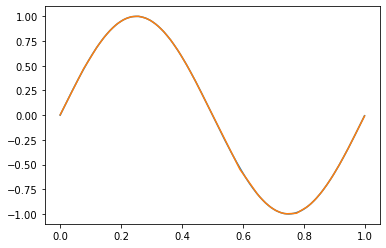

In [37]:
import matplotlib.pyplot as plt

X_test, y_test = sine_data()
dense1.forward(X_test)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
activation2.forward(dense2.output)
dense3.forward(activation2.output)
activation3.forward(dense3.output)
plt.plot(X_test, y_test)
plt.plot(X_test, activation3.output)
plt.show()

Importance of Weight Initialization:
 - weight initialization is important can result in a model fitting pretty well at default optimizer settings vs. not fitting at all
 - the book notes that if you change the weight initializion from .01 * random distriution to .1, then the model learns much better at any adam initialization
 - Example of weight intializer: Glorot Uniform
 - Glorot Uniform randomly draws weight intializations from a uniform distribtion
  1) the limits (edges) of the uniform distribution is defined as limits = sqrt(6 / (fan_in+fan_out)). Where fan_in is the number of inputs in the weight tensor(array) and fan_out is the number of outputs in the weight tensor. So we will draw weight values from [-limit, limit]. These can be scaled by any amount (e.g., .01 or 1)
 - in the book, we just adjust the scaling of the weight intialization on a normal distribution by changing it from .01 to .1, which is different than glorot because glorot distribution changes with the number of input and output neurons, ours does not.


All Model Objects Up To This Point
- Run this cell for the Regression cell above to run
- dropped in completely fresh code from NNFS github
- Note that we changed the self.weights intialization from .01 to .1, because this results in better performance on the regression

In [34]:
import numpy as np
import nnfs
from nnfs.datasets import sine_data

nnfs.init()


# Dense layer
class Layer_Dense:

    # Layer initialization
    def __init__(self, n_inputs, n_neurons,
                 weight_regularizer_l1=0, weight_regularizer_l2=0,
                 bias_regularizer_l1=0, bias_regularizer_l2=0):
        # Initialize weights and biases
        self.weights = 0.1 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
        # Set regularization strength
        self.weight_regularizer_l1 = weight_regularizer_l1
        self.weight_regularizer_l2 = weight_regularizer_l2
        self.bias_regularizer_l1 = bias_regularizer_l1
        self.bias_regularizer_l2 = bias_regularizer_l2

    # Forward pass
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs
        # Calculate output values from inputs, weights and biases
        self.output = np.dot(inputs, self.weights) + self.biases

    # Backward pass
    def backward(self, dvalues):
        # Gradients on parameters
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)


        # Gradients on regularization
        # L1 on weights
        if self.weight_regularizer_l1 > 0:
            dL1 = np.ones_like(self.weights)
            dL1[self.weights < 0] = -1
            self.dweights += self.weight_regularizer_l1 * dL1
        # L2 on weights
        if self.weight_regularizer_l2 > 0:
            self.dweights += 2 * self.weight_regularizer_l2 * \
                             self.weights
        # L1 on biases
        if self.bias_regularizer_l1 > 0:
            dL1 = np.ones_like(self.biases)
            dL1[self.biases < 0] = -1
            self.dbiases += self.bias_regularizer_l1 * dL1
        # L2 on biases
        if self.bias_regularizer_l2 > 0:
            self.dbiases += 2 * self.bias_regularizer_l2 * \
                            self.biases

        # Gradient on values
        self.dinputs = np.dot(dvalues, self.weights.T)


# Dropout
class Layer_Dropout:

    # Init
    def __init__(self, rate):
        # Store rate, we invert it as for example for dropout
        # of 0.1 we need success rate of 0.9
        self.rate = 1 - rate

    # Forward pass
    def forward(self, inputs):
        # Save input values
        self.inputs = inputs
        # Generate and save scaled mask
        self.binary_mask = np.random.binomial(1, self.rate,
                           size=inputs.shape) / self.rate
        # Apply mask to output values
        self.output = inputs * self.binary_mask

    # Backward pass
    def backward(self, dvalues):
        # Gradient on values
        self.dinputs = dvalues * self.binary_mask

# ReLU activation
class Activation_ReLU:

    # Forward pass
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs
        # Calculate output values from inputs
        self.output = np.maximum(0, inputs)

    # Backward pass
    def backward(self, dvalues):
        # Since we need to modify original variable,
        # let's make a copy of values first
        self.dinputs = dvalues.copy()

        # Zero gradient where input values were negative
        self.dinputs[self.inputs <= 0] = 0


# Softmax activation
class Activation_Softmax:

    # Forward pass
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs

        # Get unnormalized probabilities
        exp_values = np.exp(inputs - np.max(inputs, axis=1,
                                            keepdims=True))
        # Normalize them for each sample
        probabilities = exp_values / np.sum(exp_values, axis=1,
                                            keepdims=True)

        self.output = probabilities

    # Backward pass
    def backward(self, dvalues):

        # Create uninitialized array
        self.dinputs = np.empty_like(dvalues)

        # Enumerate outputs and gradients
        for index, (single_output, single_dvalues) in \
                enumerate(zip(self.output, dvalues)):
            # Flatten output array
            single_output = single_output.reshape(-1, 1)

            # Calculate Jacobian matrix of the output
            jacobian_matrix = np.diagflat(single_output) - \
                              np.dot(single_output, single_output.T)
            # Calculate sample-wise gradient
            # and add it to the array of sample gradients
            self.dinputs[index] = np.dot(jacobian_matrix,
                                         single_dvalues)


# Sigmoid activation
class Activation_Sigmoid:

    # Forward pass
    def forward(self, inputs):
        # Save input and calculate/save output
        # of the sigmoid function
        self.inputs = inputs
        self.output = 1 / (1 + np.exp(-inputs))

    # Backward pass
    def backward(self, dvalues):
        # Derivative - calculates from output of the sigmoid function
        self.dinputs = dvalues * (1 - self.output) * self.output


# Linear activation
class Activation_Linear:

    # Forward pass
    def forward(self, inputs):
        # Just remember values
        self.inputs = inputs
        self.output = inputs

    # Backward pass
    def backward(self, dvalues):
        # derivative is 1, 1 * dvalues = dvalues - the chain rule
        self.dinputs = dvalues.copy()


# SGD optimizer
class Optimizer_SGD:

    # Initialize optimizer - set settings,
    # learning rate of 1. is default for this optimizer
    def __init__(self, learning_rate=1., decay=0., momentum=0.):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.momentum = momentum

    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                (1. / (1. + self.decay * self.iterations))

    # Update parameters
    def update_params(self, layer):

        # If we use momentum
        if self.momentum:

            # If layer does not contain momentum arrays, create them
            # filled with zeros
            if not hasattr(layer, 'weight_momentums'):
                layer.weight_momentums = np.zeros_like(layer.weights)
                # If there is no momentum array for weights
                # The array doesn't exist for biases yet either.
                layer.bias_momentums = np.zeros_like(layer.biases)

            # Build weight updates with momentum - take previous
            # updates multiplied by retain factor and update with
            # current gradients
            weight_updates = \
                self.momentum * layer.weight_momentums - \
                self.current_learning_rate * layer.dweights
            layer.weight_momentums = weight_updates

            # Build bias updates
            bias_updates = \
                self.momentum * layer.bias_momentums - \
                self.current_learning_rate * layer.dbiases
            layer.bias_momentums = bias_updates

        # Vanilla SGD updates (as before momentum update)
        else:
            weight_updates = -self.current_learning_rate * \
                             layer.dweights
            bias_updates = -self.current_learning_rate * \
                           layer.dbiases

        # Update weights and biases using either
        # vanilla or momentum updates
        layer.weights += weight_updates
        layer.biases += bias_updates
    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1


# Adagrad optimizer
class Optimizer_Adagrad:

    # Initialize optimizer - set settings
    def __init__(self, learning_rate=1., decay=0., epsilon=1e-7):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon

    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                (1. / (1. + self.decay * self.iterations))

    # Update parameters
    def update_params(self, layer):

        # If layer does not contain cache arrays,
        # create them filled with zeros
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)

        # Update cache with squared current gradients
        layer.weight_cache += layer.dweights**2
        layer.bias_cache += layer.dbiases**2

        # Vanilla SGD parameter update + normalization
        # with square rooted cache
        layer.weights += -self.current_learning_rate * \
                         layer.dweights / \
                         (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases += -self.current_learning_rate * \
                        layer.dbiases / \
                        (np.sqrt(layer.bias_cache) + self.epsilon)

    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1

# RMSprop optimizer
class Optimizer_RMSprop:

    # Initialize optimizer - set settings
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7,
                 rho=0.9):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.rho = rho

    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                (1. / (1. + self.decay * self.iterations))

    # Update parameters
    def update_params(self, layer):

        # If layer does not contain cache arrays,
        # create them filled with zeros
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)

        # Update cache with squared current gradients
        layer.weight_cache = self.rho * layer.weight_cache + \
            (1 - self.rho) * layer.dweights**2
        layer.bias_cache = self.rho * layer.bias_cache + \
            (1 - self.rho) * layer.dbiases**2

        # Vanilla SGD parameter update + normalization
        # with square rooted cache
        layer.weights += -self.current_learning_rate * \
                         layer.dweights / \
                         (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases += -self.current_learning_rate * \
                        layer.dbiases / \
                        (np.sqrt(layer.bias_cache) + self.epsilon)

    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1


# Adam optimizer
class Optimizer_Adam:

    # Initialize optimizer - set settings
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7,
                 beta_1=0.9, beta_2=0.999):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2

    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                (1. / (1. + self.decay * self.iterations))

    # Update parameters
    def update_params(self, layer):

        # If layer does not contain cache arrays,
        # create them filled with zeros
        if not hasattr(layer, 'weight_cache'):
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.bias_cache = np.zeros_like(layer.biases)

        # Update momentum  with current gradients
        layer.weight_momentums = self.beta_1 * \
                                 layer.weight_momentums + \
                                 (1 - self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * \
                               layer.bias_momentums + \
                               (1 - self.beta_1) * layer.dbiases
        # Get corrected momentum
        # self.iteration is 0 at first pass
        # and we need to start with 1 here
        weight_momentums_corrected = layer.weight_momentums / \
            (1 - self.beta_1 ** (self.iterations + 1))
        bias_momentums_corrected = layer.bias_momentums / \
            (1 - self.beta_1 ** (self.iterations + 1))
        # Update cache with squared current gradients
        layer.weight_cache = self.beta_2 * layer.weight_cache + \
            (1 - self.beta_2) * layer.dweights**2
        layer.bias_cache = self.beta_2 * layer.bias_cache + \
            (1 - self.beta_2) * layer.dbiases**2
        # Get corrected cache
        weight_cache_corrected = layer.weight_cache / \
            (1 - self.beta_2 ** (self.iterations + 1))
        bias_cache_corrected = layer.bias_cache / \
            (1 - self.beta_2 ** (self.iterations + 1))

        # Vanilla SGD parameter update + normalization
        # with square rooted cache
        layer.weights += -self.current_learning_rate * \
                         weight_momentums_corrected / \
                         (np.sqrt(weight_cache_corrected) +
                             self.epsilon)
        layer.biases += -self.current_learning_rate * \
                         bias_momentums_corrected / \
                         (np.sqrt(bias_cache_corrected) +
                             self.epsilon)

    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1


# Common loss class
class Loss:

    # Regularization loss calculation
    def regularization_loss(self, layer):

        # 0 by default
        regularization_loss = 0

        # L1 regularization - weights
        # calculate only when factor greater than 0
        if layer.weight_regularizer_l1 > 0:
            regularization_loss += layer.weight_regularizer_l1 * \
                                   np.sum(np.abs(layer.weights))

        # L2 regularization - weights
        if layer.weight_regularizer_l2 > 0:
            regularization_loss += layer.weight_regularizer_l2 * \
                                   np.sum(layer.weights * \
                                          layer.weights)


        # L1 regularization - biases
        # calculate only when factor greater than 0
        if layer.bias_regularizer_l1 > 0:
            regularization_loss += layer.bias_regularizer_l1 * \
                                   np.sum(np.abs(layer.biases))

        # L2 regularization - biases
        if layer.bias_regularizer_l2 > 0:
            regularization_loss += layer.bias_regularizer_l2 * \
                                   np.sum(layer.biases * \
                                          layer.biases)

        return regularization_loss

    # Calculates the data and regularization losses
    # given model output and ground truth values
    def calculate(self, output, y):

        # Calculate sample losses
        sample_losses = self.forward(output, y)

        # Calculate mean loss
        data_loss = np.mean(sample_losses)

        # Return loss
        return data_loss


# Cross-entropy loss
class Loss_CategoricalCrossentropy(Loss):

    # Forward pass
    def forward(self, y_pred, y_true):

        # Number of samples in a batch
        samples = len(y_pred)

        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

        # Probabilities for target values -
        # only if categorical labels
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[
                range(samples),
                y_true
            ]
        # Mask values - only for one-hot encoded labels
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(
                y_pred_clipped * y_true,
                axis=1
            )

        # Losses
        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods

    # Backward pass
    def backward(self, dvalues, y_true):

        # Number of samples
        samples = len(dvalues)
        # Number of labels in every sample
        # We'll use the first sample to count them
        labels = len(dvalues[0])

        # If labels are sparse, turn them into one-hot vector
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]

        # Calculate gradient
        self.dinputs = -y_true / dvalues
        # Normalize gradient
        self.dinputs = self.dinputs / samples


# Softmax classifier - combined Softmax activation
# and cross-entropy loss for faster backward step
class Activation_Softmax_Loss_CategoricalCrossentropy():

    # Creates activation and loss function objects
    def __init__(self):
        self.activation = Activation_Softmax()
        self.loss = Loss_CategoricalCrossentropy()

    # Forward pass
    def forward(self, inputs, y_true):
        # Output layer's activation function
        self.activation.forward(inputs)
        # Set the output
        self.output = self.activation.output
        # Calculate and return loss value
        return self.loss.calculate(self.output, y_true)

    # Backward pass
    def backward(self, dvalues, y_true):

        # Number of samples
        samples = len(dvalues)

        # If labels are one-hot encoded,
        # turn them into discrete values
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)

        # Copy so we can safely modify
        self.dinputs = dvalues.copy()
        # Calculate gradient
        self.dinputs[range(samples), y_true] -= 1
        # Normalize gradient
        self.dinputs = self.dinputs / samples


# Binary cross-entropy loss
class Loss_BinaryCrossentropy(Loss):

    # Forward pass
    def forward(self, y_pred, y_true):

        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

        # Calculate sample-wise loss
        sample_losses = -(y_true * np.log(y_pred_clipped) +
                          (1 - y_true) * np.log(1 - y_pred_clipped))
        sample_losses = np.mean(sample_losses, axis=-1)

        # Return losses
        return sample_losses

    # Backward pass
    def backward(self, dvalues, y_true):

        # Number of samples
        samples = len(dvalues)
        # Number of outputs in every sample
        # We'll use the first sample to count them
        outputs = len(dvalues[0])

        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        clipped_dvalues = np.clip(dvalues, 1e-7, 1 - 1e-7)

        # Calculate gradient
        self.dinputs = -(y_true / clipped_dvalues -
                         (1 - y_true) / (1 - clipped_dvalues)) / outputs
        # Normalize gradient
        self.dinputs = self.dinputs / samples


# Mean Squared Error loss
class Loss_MeanSquaredError(Loss):  # L2 loss

    # Forward pass
    def forward(self, y_pred, y_true):

        # Calculate loss
        sample_losses = np.mean((y_true - y_pred)**2, axis=-1)

        # Return losses
        return sample_losses

    # Backward pass
    def backward(self, dvalues, y_true):

        # Number of samples
        samples = len(dvalues)
        # Number of outputs in every sample
        # We'll use the first sample to count them
        outputs = len(dvalues[0])

        # Gradient on values
        self.dinputs = -2 * (y_true - dvalues) / outputs
        # Normalize gradient
        self.dinputs = self.dinputs / samples


# Mean Absolute Error loss
class Loss_MeanAbsoluteError(Loss):  # L1 loss

    # Forward pass
    def forward(self, y_pred, y_true):

        # Calculate loss
        sample_losses = np.mean(np.abs(y_true - y_pred), axis=-1)

        # Return losses
        return sample_losses


    # Backward pass
    def backward(self, dvalues, y_true):

        # Number of samples
        samples = len(dvalues)
        # Number of outputs in every sample
        # We'll use the first sample to count them
        outputs = len(dvalues[0])

        # Calculate gradient
        self.dinputs = np.sign(y_true - dvalues) / outputs
        # Normalize gradient
        self.dinputs = self.dinputs / samples